In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from model_reddit import CFTModelReddit
from baselines import SurvivalModel, PosNegModel

- need to balance c = 1 and c = 0

In [2]:
# get reddit files

import glob
filenames = glob.glob('/scratch/mme4/reddit/*.pickle')
print('There are %i files (%i total users)' % (len(filenames), 400 * len(filenames)))

train_filenames = filenames[:int(.6 * len(filenames))]
val_filenames = filenames[int(.6 * len(filenames)):int(.8 * len(filenames))]
test_filenames = filenames[int(.8 * len(filenames)):]

print(len(train_filenames), len(val_filenames), len(test_filenames))

There are 686 files (274400 total users)
411 137 138


Completed Epoch 0
Completed Epoch 1
Completed Epoch 2
Completed Epoch 3
Completed Epoch 4
Completed Epoch 5
Completed Epoch 6
Completed Epoch 7
Completed Epoch 8
Completed Epoch 9
Completed Epoch 10
Completed Epoch 11
Completed Epoch 12
Completed Epoch 13
Completed Epoch 14


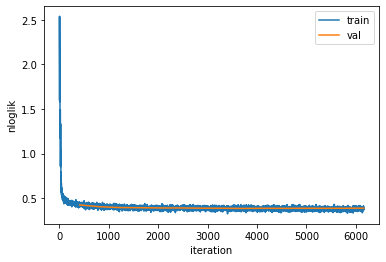

In [3]:
# Run CFT Model

tf.reset_default_graph()

cft_mdl = CFTModelReddit(
    embedding_layer_sizes=(300,),
    encoder_layer_sizes=(100,),
    decoder_layer_sizes=(100,),
    estimator='gs',
    fpr_likelihood=True,
    fpr=.5,
    prop_fpr=True,
    gs_temperature=.3,
    n_samples=30,
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = cft_mdl.train(
        sess, train_filenames, val_filenames,
        100, max_epochs_no_improve=5, learning_rate=3e-4,
        verbose=False)
    c_pred_cft, t_pred_cft, c_val, t_val, s_val = cft_mdl.predict_c_and_t(sess, val_filenames)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

In [4]:
[np.sum(c_val[:, i] == 1) / len(c_val) for i in range(9)]

[0.07217153284671533,
 0.10164233576642336,
 0.13264598540145986,
 0.20983576642335766,
 0.2937043795620438,
 0.22594890510948906,
 0.04322992700729927,
 0.09129562043795621,
 0.0021350364963503648]

In [5]:
pd.value_counts([np.sum(c_val[i, :]) for i in range(len(c_val))])

1.0    47049
2.0     6387
3.0     1091
4.0      216
5.0       45
6.0       10
7.0        2
dtype: int64

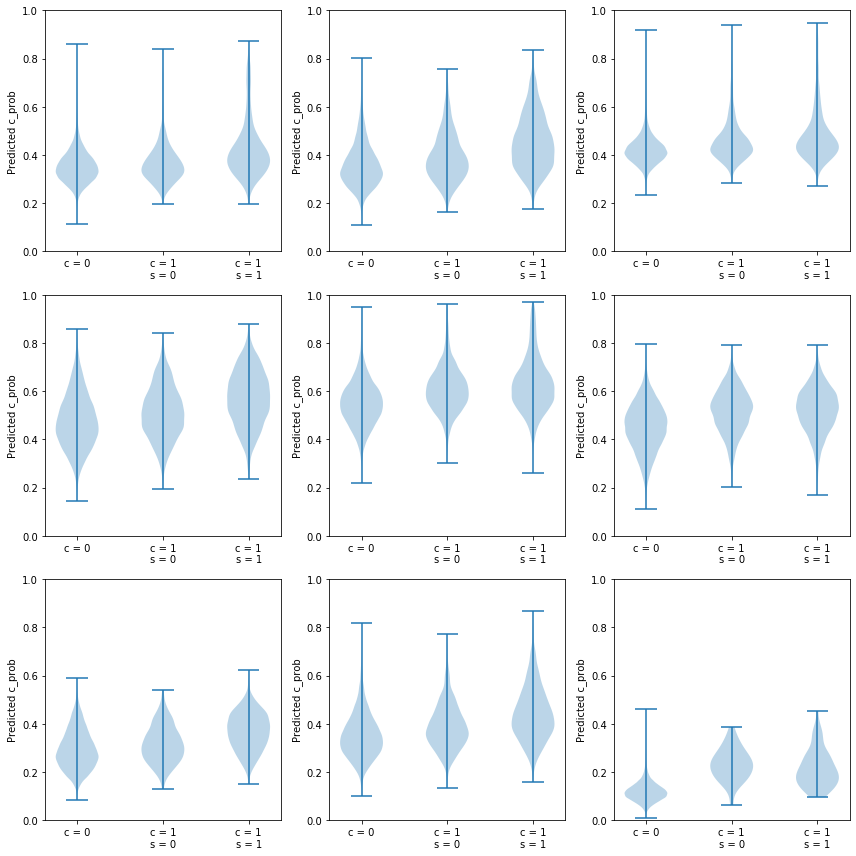

In [6]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

for i in range(9):
    if np.sum(c_val[:, i]) > 1:
        ax[i // 3, i % 3].violinplot([
            c_pred_cft[c_val[:, i] == 0, i],
            c_pred_cft[(c_val[:, i] == 1) & (s_val[:, i] == 0), i],
            c_pred_cft[(c_val[:, i] == 1) & (s_val[:, i] == 1), i]])
        ax[i // 3, i % 3].set_xticks([1, 2, 3])
        ax[i // 3, i % 3].set_xticklabels(['c = 0', 'c = 1\ns = 0', 'c = 1\ns = 1'])
        ax[i // 3, i % 3].set_ylabel('Predicted c_prob')
        ax[i // 3, i % 3].set_ylim([0, 1])
    
plt.tight_layout()
plt.show()

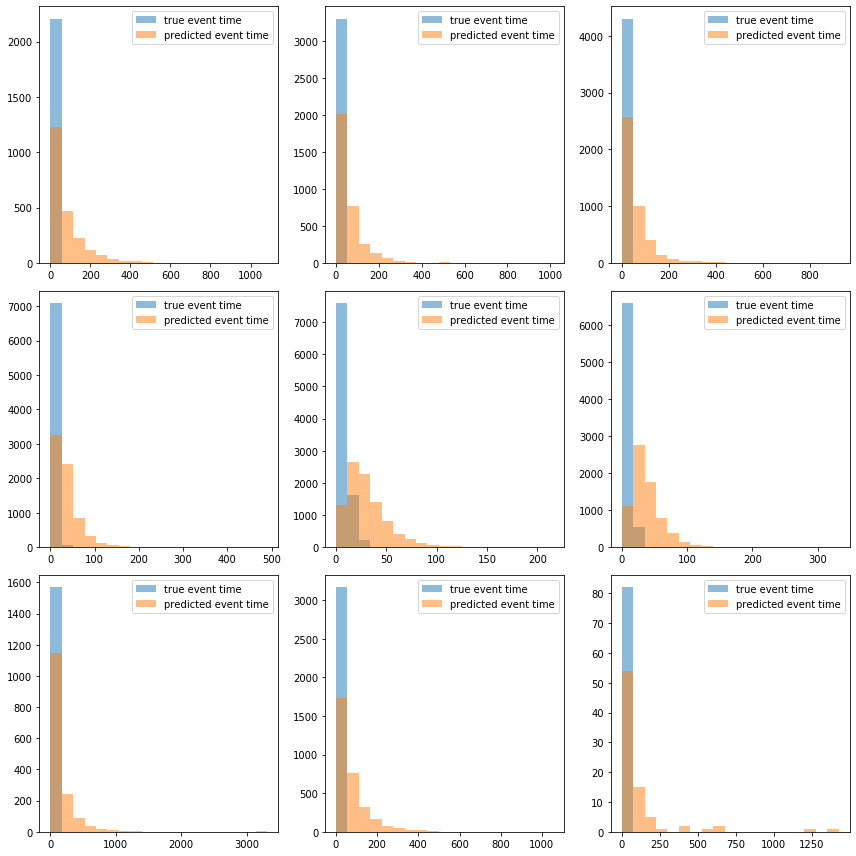

In [15]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

for i in range(9):
    if np.sum(c_val[:, i]) > 1:
        max_time = t_val[s_val[:, i] == 1, i].max() + np.median(t_pred_cft, axis=1)[s_val[:, i] == 1, i].max()
        bins = np.linspace(0, max_time, 20)
        ax[i // 3, i % 3].hist(t_val[s_val[:, i] == 1, i],
                               bins=bins, alpha=.5, label='true event time')
        ax[i // 3, i % 3].hist(np.median(t_pred_cft, axis=1)[s_val[:, i] == 1, i],
                               bins=bins, alpha=.5, label='predicted event time')
        ax[i // 3, i % 3].legend()
    
plt.tight_layout()
plt.show()

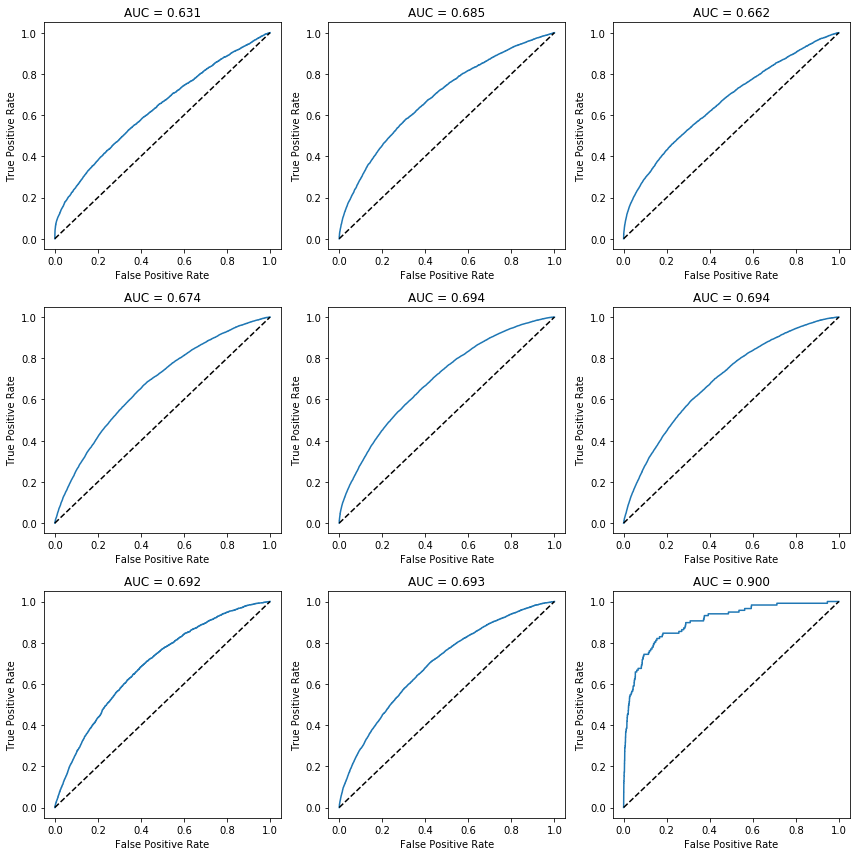

In [8]:
# CFT performance in predicting c

from sklearn.metrics import roc_curve, roc_auc_score

fig, ax = plt.subplots(3, 3, figsize=(12, 12))

for i in range(9):
    fpr, tpr, _ = roc_curve(c_val[:, i], c_pred_cft[:, i])
    ax[i // 3, i % 3].plot(fpr, tpr)
    ax[i // 3, i % 3].plot([0, 1], [0, 1], 'k--')
    ax[i // 3, i % 3].set_xlabel('False Positive Rate')
    ax[i // 3, i % 3].set_ylabel('True Positive Rate')
    ax[i // 3, i % 3].set_title('AUC = %.3f' % roc_auc_score(c_val[:, i], c_pred_cft[:, i]))

plt.tight_layout()
plt.show()

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90
Completed Epoch 100
Completed Epoch 110
Completed Epoch 120
Completed Epoch 130
Completed Epoch 140
Completed Epoch 150
Completed Epoch 160
Completed Epoch 170
Completed Epoch 180
Completed Epoch 190


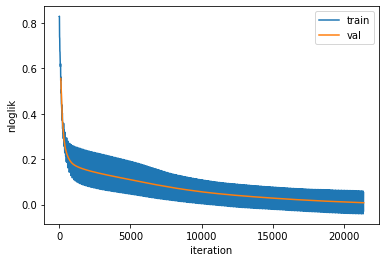

In [51]:
# Train deep survival model (not conditional)

tf.reset_default_graph()

surv_mdl = SurvivalModel(
    decoder_layer_sizes=(100,),
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = surv_mdl.train(
        sess, x_train, t_train, s_train, x_val, t_val, s_val,
        200, max_epochs_no_improve=2, learning_rate=3e-4,
        verbose=False)
    t_pred_surv = surv_mdl.predict_t(sess, x_val)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90
Completed Epoch 100
Completed Epoch 110
Completed Epoch 120
Completed Epoch 130
Completed Epoch 140
Completed Epoch 150
Completed Epoch 160
Completed Epoch 170
Completed Epoch 180
Completed Epoch 190


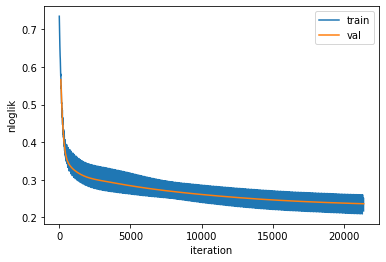

In [52]:
# Train MLP to predict s directly

tf.reset_default_graph()

posneg_mdl = PosNegModel(
    encoder_layer_sizes=(100,),
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = posneg_mdl.train(
        sess, x_train, s_train, x_val, s_val,
        200, max_epochs_no_improve=2, learning_rate=3e-4,
        verbose=False)
    s_pred_posneg = posneg_mdl.predict_prob(sess, x_val)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

Completed Epoch 0
Completed Epoch 10
Completed Epoch 20
Completed Epoch 30
Completed Epoch 40
Completed Epoch 50
Completed Epoch 60
Completed Epoch 70
Completed Epoch 80
Completed Epoch 90
Completed Epoch 100
Completed Epoch 110
Completed Epoch 120
Completed Epoch 130
Completed Epoch 140
Completed Epoch 150
Completed Epoch 160
Completed Epoch 170
Completed Epoch 180
Completed Epoch 190


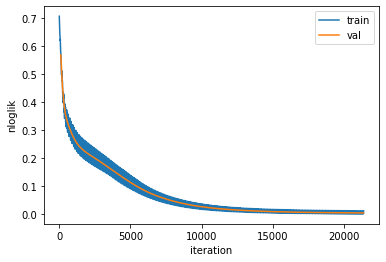

In [53]:
# Train MLP to predict c directly (to see optimal classification performance)

tf.reset_default_graph()

c_mdl = PosNegModel(
    encoder_layer_sizes=(100,),
    dropout_pct=.5)
with tf.Session() as sess:
    train_stats, val_stats = c_mdl.train(
        sess, x_train, c_train, x_val, c_val,
        200, max_epochs_no_improve=2, learning_rate=3e-4,
        verbose=False)
    c_pred_posneg = c_mdl.predict_prob(sess, x_val)
    
train_stats = list(zip(*train_stats))
val_stats = list(zip(*val_stats))

plt.plot(train_stats[0], train_stats[1], label='train')
plt.plot(val_stats[0], val_stats[1], label='val')
plt.xlabel('iteration')
plt.ylabel('nloglik')
plt.legend()
plt.show()

- make it a little more difficult, gaps may get a bit larger. Try to get confidence intervals on AUCs. Bootstrapping or Delong.

- need to present c-index for time to event

- start by increasing weight of term 2 in the objective